# Particle Filter, Robot in a room

Its is required to estimate position of a robot in room with known dimensions. Using particle filter, we estimate its position under very noisy measurments

## Robot Model and simulation

Consider a room $(X, Y) \in [-1, 1]^2$. The robot starts at (-0.5, -0.5) and follows a wavy-star trajectory. Its coordinates are measured but with lot of noise. Let $(x_1(t), x_2(t))$ denote the position of robot time $t$. Let $(v_1, v_2)$ denote the velocity of robot in directions $x_1, x_2$ repectively however not without some additional modelling noise

$\frac{dx_1(t)}{dt}=v_1+w_1$

$\frac{dx_2(t)}{dt}=v_2+w_2$

Here, $(w_1, w_2)$ denotes zero mean Gaussian noise. We are measuring $(x_1, x_2)$ with zero mean uniform noise.

In [1]:
#Importing libraries
import numpy as np
import matplotlib.pyplot as plt
from math import *
import random
import scipy.linalg as sp

### Python Implementation

1. Function 'f': takes arguments x, v1, v2 and returns an array(v1, v2). f may not in general be such a simple function, but for purpuse of generality its implemented as such. Its basically the propagation model i.e. $\frac{dX}{dt}=f(x, v)$

2. Function 'g'; takes in argument x and a bool 'noise'. In our case it returns x if noise is False else it generates uniform random noise $w_1, w_2$ both $\in (-0.1, 0.1)$ and adds to x and returns it

3. A python class Robot with attributes x1, x2 denoting position inside room, initialised to $(-0.5, -0.5)$. A member function prop which takes in arguments (v1, v2, T, noise). v1, v2 being velocities in $(x_1, x_2)$ and T being time step. If noise is true, then add modelling noise which is $0$ mean and covariance $R$ being $I_{2x2}10^{-4}$. Another trivial function 'getX' takes no argument and returns current position (x1, x2)

In [2]:
def f(x, v1, v2):
    
    #Propagation Model i.e dx/dt, v1 and v2 are velocities, x is not used but provided 
    #because f may not in general be independent of x
    
    return np.array([v1, v2])

def g(x, noise=False):
    
    #Measurement Model, if noise=True then add noise to measurement
    if noise:
        v=[random.uniform(-0.1, 0.1), random.uniform(-0.1, 0.1)]
        return x[0]+v[0], x[1]+v[1]
    else:
        return x[0], x[1]

class Robot(object):
    
    #Robot Model
    def __init__(self):
        #Initialisation of position
        self.x1=-0.5
        self.x2=-0.5
    
    def prop(self, v1, v2, T, noise=True):
        #Propagation Model
        R=np.identity(2)*1e-4 
        v=np.random.multivariate_normal([0, 0], R)
        self.x1+=T*v1+v[0]
        self.x2+=T*v2+v[1]
    
    def getX(self):
        #Get actual coordinates
        return np.array([self.x1, self.x2])

### Simulation

Taking $T=0.01s$, we simulate for 51 time steps with velocity vector $(1, 2.4)$. Followed by $v=(1, -2.4)$ for 50 time steps. Then $v=(-2.4, 1.4)$ for 50 time steps, then $v=(2.8, 0)$ for 50 time steps and finally $v=(-2.4, -1.4)$ for 50 time steps. Along the path we generate the noisy measurements which we shall use in our particle filter algorithm

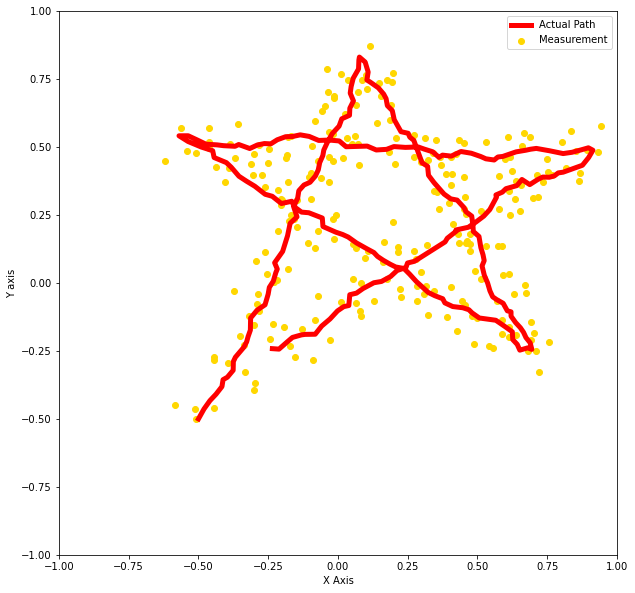

In [3]:
a=Robot()   #Initial a robot
T=0.01      #Time Step
V=[]        #Velocity input
X1=[]       #Actual position-X
X2=[]       #Actual position-Y
Y1=[]       #Measurement of X
Y2=[]       #Measurement of Y

#Form a Star Trajectory
for i in range(0, 51):
    
    x=a.getX()
    X1.append(x[0])
    X2.append(x[1])
    y=g(x, True)
    Y1.append(y[0])
    Y2.append(y[1])
    v1=1
    v2=2.4
    V.append([v1, v2])
    a.prop(v1, v2, T)

for i in range(51, 101):
    
    x=a.getX()
    X1.append(x[0])
    X2.append(x[1])
    y=g(x, True)
    Y1.append(y[0])
    Y2.append(y[1])
    v1=1
    v2=-2.4
    V.append([v1, v2])
    a.prop(v1, v2, T)
    
for i in range(101, 151):
    
    x=a.getX()
    X1.append(x[0])
    X2.append(x[1])
    y=g(x, True)
    Y1.append(y[0])
    Y2.append(y[1])
    v1=-2.4
    v2=1.4
    V.append([v1, v2])
    a.prop(v1, v2, T)
    
for i in range(151, 201):
    
    x=a.getX()
    X1.append(x[0])
    X2.append(x[1])
    y=g(x, True)
    Y1.append(y[0])
    Y2.append(y[1])
    v1=2.8
    v2=0
    V.append([v1, v2])
    a.prop(v1, v2, T)
    
for i in range(201, 251):
    
    x=a.getX()
    X1.append(x[0])
    X2.append(x[1])
    y=g(x, True)
    Y1.append(y[0])
    Y2.append(y[1])
    v1=-2.4
    v2=-1.4
    V.append([v1, v2])
    a.prop(v1, v2, T)
    
plt.figure(figsize=(10, 10))
plt.plot(X1, X2, 'red', lw=5)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.scatter(Y1, Y2, color='gold')
plt.xlabel('X Axis')
plt.ylabel('Y axis')
plt.legend(['Actual Path', 'Measurement'])
plt.show()

## Particle Filter

A bunch of Particles (hypothesis about robot position) are generated randomly (uniformly sampled in room with known dimensions). Based on the velocity (control variable), all hypothesis points are propagated through the model for a time step. Also measurement model is known which is used to generate measurement predictions. The measurements which are far off from actual measurements are assigned lower weight. Some low weight samples are discarded and new hypothesis points are generated.

### Implementation

A 'Particle' class with attributes x (2D position vector), w (weight), y (measurement), functions to modify or obtain attributes, 'propagate' function that takes arguments f, u, T (propagation function, function arguments and time step respectively), 'meas' function that takes argument 'g (measurement function), 'distance' function that takes argument y and returns distance (Euclidean) between self.y and y.

A 'PFilter' class with attributes Particles (list of particle class objects), count (number of particles), wsum (sum of weights), N (dimension of particles' x vector). Its attribute functions are as follows:

1. RandomSample(n, N, limits): n- number of particles, N- dimension of particles, limits (a list containing upper and lower limits for uniform sampling, in our case its [[-1, 1], [-1, 1]] i.e. dimensions of the room). This function basically initisalises the Particle Filter. It generates samples and assigns a equal weight 1/n to all particles.

2. retVals(thresh): thresh has default value 0, all the particles with weights >=thresh have their data formed in suitable matrix and returned.

3. Prop(f, u, g, y, T): 'f' the propagation function, u - arguments of 'f', 'g' measurement function, y - actual measurement, T- time step with default value 0.01. This function propagates all particles thorugh the model f with argument u, then generates measurement estimate from model g and computes its distance from actual measurement y. Then each particle $i$ is assigned a weight proportional to $1-d_i/\Sigma_j d_j$ such that sum of weights of all particles is 1

4. getwsum(): returns sum of weights of all particles. It was used during debugging process

5. Resample(limits, y, g): This is where design part comes in. For different cases different function may be suited. For our case since we can draw samples from the distribution which is uniform random in the room with known dimensions, we pass in three arguments 'limits' (which is similar to one in RandomSample), 'y' - actual measurement and 'g'- measurement function. All the particles which have weight greater than 1/C, with C being number of particles, are retained. To make up the lost particles, random samples are again uniformly drawn until we have the same count as before. Then we generate measurement predictions and compare with actual measurement and assign weights as in 'Prop'

6. getStats(thresh, y): compute distance of all samples from y and generate weights same as before. Return the mean of x of particles with weight > thresh. thresh and y have default values 0.

In [4]:
class Particle(object):
    
    def __init__(self):
        
        self.x=np.zeros(2)
        self.w=1
        self.y=0
        
    def getX(self):
        return self.x
    
    def getw(self):
        return self.w
    
    def setw(self, w):
        self.w=w
    
    def setX(self, X):
        self.x=X
        
    def setY(self, y):
        self.y=y
        
    def getY(self):
        return self.y  
    
    def propagate(self, f, u, T): 
        self.x=self.x+T*f(self.x, *u)
        
    def meas(self, g):
        return g(self.x)
    
    def distance(self, y):
        d=0
        for i in range(0, len(self.x)):
            d+=(self.x[i]-y[i])**2
        return sqrt(d)
        

class PFilter(object):
    
    def __init__(self):
        
        self.Particles=[]
        self.count=0
        self.wsum=0
        self.N=0
        
    #Generate random Samples
    def RandomSample(self, n, N, limits):
        
        self.N=N
        self.Wsum=0
        
        while self.count<n:
            
            X=np.zeros(N)
            for i in range(N):
                X[i]=random.uniform(*limits[i])
            P=Particle()
            P.setX(X)
            P.setw(1/n)
            self.wsum+=P.getw()
            self.Particles.append(P)
            self.count+=1
    
    #Get Values
    def retVals(self, thresh=0):
        
        N=self.N
        n=len(self.Particles)
        Data=[]
        
        for i in range(n):
            data=[]
            if self.Particles[i].getw()>thresh:
                X=self.Particles[i].getX()      
                for j in range(N):
                    data.append(X[j])
                Data.append(data)
        
        if Data:
            return np.array(Data)
        else:
            return None
         
    #Propagate particles through the model
    def Prop(self, f, u, g, y, T=0.01):
        
        Dis=[]
        
        for i in range(0, len(self.Particles)):
            self.Particles[i].propagate(f, u, T)
            Y=self.Particles[i].meas(g)
            dis=0
            for j in range(0, len(Y)):
                dis+=(Y[j]-y[j])**2
            dis=dis
            
            self.Particles[i].setw(dis)
            Dis.append(dis)
        
        self.wsum=0
        S=sum(Dis)
        for i in range(0, len(self.Particles)):
            w=self.Particles[i].getw()           
            wnew=(1-w/S)/(self.count-1)
            self.Particles[i].setw(wnew)
            self.wsum+=wnew
            
    def getwsum(self):
        return self.wsum
    
    def Resample(self, limits, y, g=g):
        C=self.count
        B=[]
        i=0
        for i in range(0, C):
            if self.Particles[i].getw()>1/C:
                B.append(self.Particles[i])
                
        self.Particles=B
        self.count=len(B)
        while self.count<C:
            X=np.zeros(self.N)
            for i in range(0, self.N):
                X[i]=random.uniform(*limits[i])
            P=Particle()
            P.setX(X)
            self.Particles.append(P)
            self.count+=1
            
        Dis=[]
        ##Redistrubute weights
        for i in range(0, len(self.Particles)):
            Y=self.Particles[i].meas(g)
            dis=0
            for j in range(0, len(Y)):
                dis+=(Y[j]-y[j])**2
            dis=dis
            
            self.Particles[i].setw(dis)
            Dis.append(dis)
        
        self.wsum=0
        S=sum(Dis)
        for i in range(0, len(self.Particles)):
            w=self.Particles[i].getw()           
            wnew=(1-w/S)/(self.count-1)
            self.Particles[i].setw(wnew)
            self.wsum+=wnew

    
    def getStats(self, thresh=0, y=0):
        
        X=np.zeros(self.N)
        Xlist=[]
        Ws=[]
        for i in range(0, self.count):
            p=self.Particles[i]
            Y=g(p.getX())
            d=0
            for j in range(0, len(Y)):
                d+=(Y[j]-y[j])**2
            d=sqrt(d)
            if d<thresh:
                Xlist.append(p.getX())
                Ws.append(p.getw())
        
        S=sum(Ws)
        for i in range(0, len(Ws)):
            X+=Xlist[i]*Ws[i]/S
        return X

## Particle Filter Simulation

In [5]:
A=PFilter()                    #Create PFilter class instance
limits=[[-1, 1], [-1, 1]]      #limits to draw samples from (room dimensions)
N=2                            #dimension of x ie 2 here
n=20                           #number of particles
A.RandomSample(n, N, limits)   #initialise the filter by 20 uniformly distributed random samples from the room                #
Xt=[]                          #Estimates of X1 from filter
Yt=[]                          #Estimates of X2 from filter

for i in range(1, 251):
    
    y=[Y1[i], Y2[i]]          #the measurement
    A.Prop(f, V[i], g, y)     #prop all particles
    xy=A.getStats(0.5, y)     #get the mean of all particles with measurement close enough to y
    A.Resample(limits, y, g)  #Resample to generate some new particles, comment this out and see what happens
    Xt.append(xy[0])          #Store estimate X1 for plotting
    Yt.append(xy[1])          #Store estimate X2 for plotting

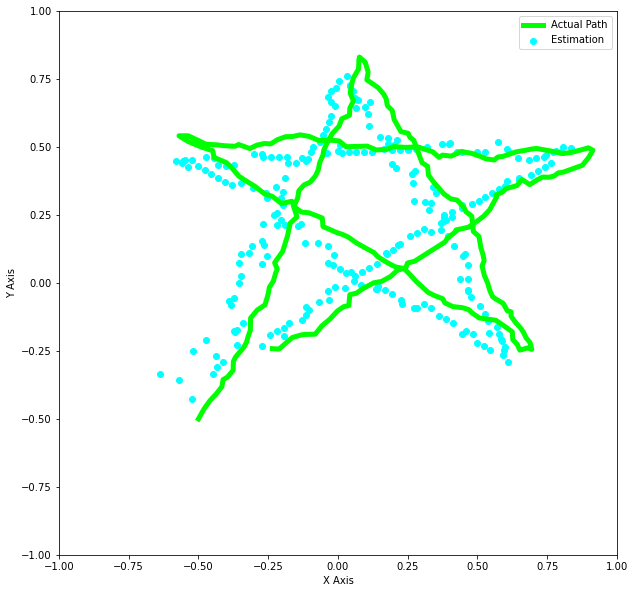

In [6]:
plt.figure(figsize=(10, 10))
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.plot(X1, X2, 'lime', lw=5)
plt.scatter(Xt, Yt, color='cyan')
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.legend(['Actual Path', 'Estimation'])
plt.show()

Near $(-0.5, -0.5)$ where we are starting the robot initially we have poor estimate of location but improves as the model is propagated